# MAC0318 - Estimação de estado - Notebook 2

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy, Matplotlib e Scipy instaladas. 
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter, a manipulação de matrizes usando a bilbioteca NumPy e conhecimento de teoria de probabilidades. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Filto de histograma unidimensional

Vamos agora assumir que nosso **domínio é a reta real**, ou seja, que o agente navega em um ambiente e seu estado é representado pela variável aleatória $X_t$ cujo suporte é $\mathbb{R}$. Para esse caso, nossa crença é uma **função de densidade** e portanto não podemos mais representá-la como um vetor de tamanho finito, como fizemos anteriormente. Para tanto, vamos adotar um **filtro de histograma**, que retringe o suporte da função de crença a um conjunto finito de **centróides**.

In [1]:
# Vamos carregar as bibliotecas necessárias

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Função de crença

O filtro de histograma representa a crença como uma somátoria de [funções de Dirac](https://en.wikipedia.org/wiki/Dirac_delta_function) centradas em pontos $x_1,\ldots,x_N$ chamados de centróides:
$$
 \text{bel}_t(x) = \sum_{c=1}^N w_{c,t} \delta(x - x_c) .
$$
A função de Diraca satisfaz a seguinte propriedade quando integrada:
$$
 \int_{-\infty}^{\infty} \delta(x-x_c) dx = 1 .
$$

Para que a função de crença definida acima seja de fato uma densidade devemos satisfazer as seguintes propriedades:
$$
 \int_{-\infty}^{\infty} \text{bel}_t(x) dx = 1 \Rightarrow \sum_c w_{c,t} \int_{-\infty}^{\infty} \delta(x-x_c) dx = \sum_c w_{c,t} = 1 .
$$
e
$$
 \text{bel}_t(x) \geq 0 \Rightarrow w_{c,t} \geq 0 .
$$
Ou seja, a função de crença é representa por um conjunto ou vetor de pesos $\{ w_{c} \}$, que satisfazem $w_c \geq 0$ e $\sum_c w_c = 1$, associados aos centróides $\{ x_c \}$.

Além dos pesos, a função de crença é parametrizada por um intervalo $[x_\text{min}, x_\text{max}]$ e pela quantidade $N$ de centróides espaçados uniformemente dentro do intervalo real. Note que nossa função sempre atribuí valor zero para qualquer estado fora desse intervalo, portanto é preciso escolher o intervalo de maneira adequada.

In [2]:
xmin, xmax = 0, 10
N = 10
centroides = np.linspace(xmin,xmax,N)

Por exemplo, uma função de crença uniforme representando máxima ignorância sobre o estado pode ser representada por um vetor como a seguir. 

In [3]:
# função de crença uniforme representada pelos seus pesos

bel = (1/N)*np.ones(N)

# Teste de consistência

bel.min() >= 0, np.allclose(1,bel.sum())

(True, True)

Vamos escrever uma função para representar visualmente a função de crença.

In [4]:
def show_belief(b):
    b = b.flatten()
    states = plt.bar(centroides, b)
    plt.xticks(centroides)
    plt.ylim([0, 1])
    plt.ylabel('bel(X)')
    plt.xlabel('X')
    plt.title('Crença')

Note que a largura das barras são apenas para visualização; a função de crença define uma densidade não nula apenas nos centróides. 

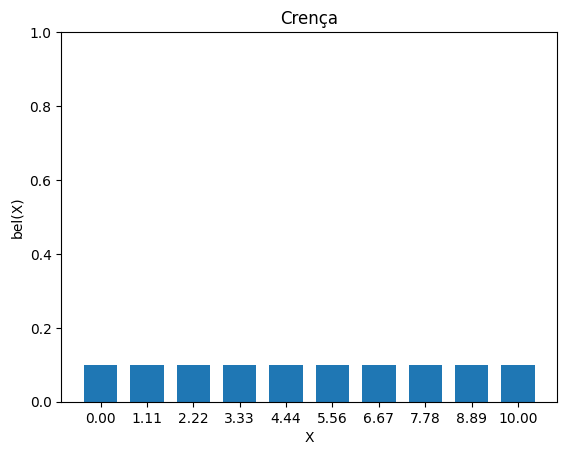

In [5]:
show_belief(bel)

Vamos considerar outra função de crença, desta vez assumindo que nosso estado é aproximadamente uma distribuição gaussiana centrada em $\mu_X = 5$ e com variância $\sigma_X^2 = 2$

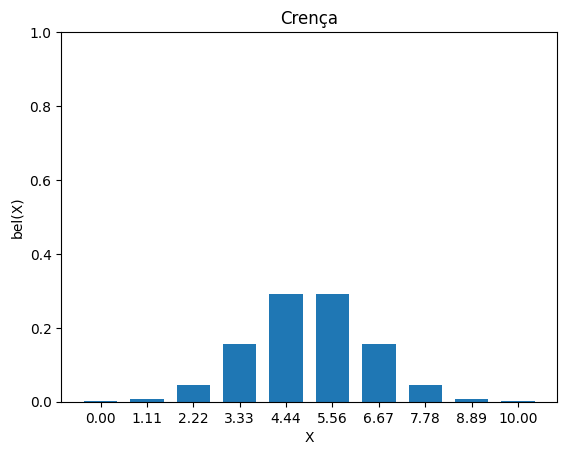

In [6]:
bel = norm.pdf(centroides, loc=5, scale=np.sqrt(2))
bel[:] = bel[:]/bel.sum()

show_belief(bel)

### Modelo de sensor

Vamos também supor que dispomos de um **sensor imperfeito** que nos fornece a posição do robô com erro modelado por uma variável gaussiana com média 0 e variância $\sigma^2$:
$$
    p(y|X_t=x) = \mathcal{N}(x, \sigma^2) .
$$

Note que agora tanto a variável de estado quanto a variável de observação são contínuas e, portanto, suas variáveis aleatórias possuem funções de densidades associadas (ao invés de distribuições de massa de probabilidades).

In [7]:
sigma2 = 1.5

def sensor(y, x): 
    ''' Return p(y|X=x). '''
    return norm.pdf(y, loc=x, scale=np.sqrt(sigma2))

Por exemplo, quando estamos em $X_t = 2$, nosso sensor retorna valores de acordo com a função de densidade abaixo

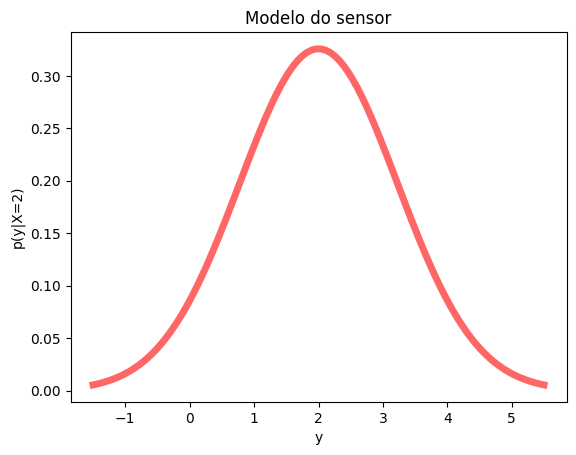

In [8]:
yspace = np.linspace(-1.5, 5.5, 100)
plt.plot(yspace, [sensor(y,2) for y in yspace], 'r-', lw=5, alpha=0.6);
plt.ylabel('p(y|X=2)');
plt.xlabel('y');
plt.title('Modelo do sensor');

### Correção

A atualização da crença para uma observação $Y_t=y$ é dada por:

$$
\begin{align}
    \text{bel}_{t+1}(x) &= p(x|y) \\
    & = \frac{p(y | x)\text{bel}_t(x)}{p(y)} \\
    & = \eta p(y|x) \sum_{c=1}^N w_{c,t}  \delta(x-x_c) ,
\end{align}
$$
onde $\eta$ é uma constante de normalização. 
Pela definição da função de Dirac, a equação acima é nula para qualquer estado diferente de um centróide, $x \neq x_c$. E para um centróide $x=x_c$, a equação se torna
$$
\text{bel}_{t+1}(x_c) = \eta p(y|x_c) w_{c,t} .
$$
A nova crença portanto tem a mesma forma anterior:
$$
    \text{bel}_{t+1}(x) = \sum_{c=1}^N w_{c,t+1}  \delta(x-x_c) ,
$$
com os novos pesos calculados por
$$
w_{c,t+1} = \eta p(y|x_c) w_{c,t}
$$
e
$$
 \eta = \sum_{c=1}^N  p(y|x) w_{c,t} .
$$
Note que do ponto de vista computacional, a atualização é similar ao filtro bayesiano discreto: computamos o produto ponto-a-ponto da crença antiga pelo modelo de sensor em cada centróide e renormalizamos o vetor resultante. 

In [9]:
def correct(b, y):
    ''' Update belief vector b given observation y -- Calls sensor model sensor(y) = p(Y=y|x).  '''
    tilde_bel = np.array([sensor(y,x) for x in centroides]).T # p(Y=y|X=x)
    tilde_bel *= b # bel(X) * p(y|X)
    # normaliza e atualiza vetor de crença
    b[:] = tilde_bel/np.sum(tilde_bel) 

Vamos testar o algoritmo supondo uma observação de $y=0.9$

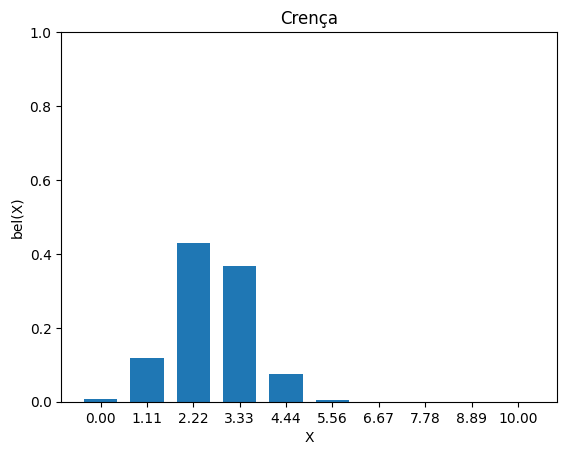

In [10]:
# observa Y=0.9

correct(bel, 0.9)

show_belief(bel) 

Note como a nova crença se concentra ao redor do valor medido, reflentindo uma redução da incerteza (entropia) da estimação de estado.

### Modelo de transição

Para o modelo de transição, vamos assumir que o robô executa uma ação de se mover $u$ unidades em um intervalo $[-1,1]$, resultando no seguinte estado:
$$
  x_{t+1} = x_t + u + k*u*\epsilon ,
$$

com $\epsilon$ sendo uma variável gaussiana com média 0 e variância 1. A constante $k$ regula a variância da imprecisão do movimento. A função de densidade da transição é portanto dada por
$$
p(x_{t+1} | x_t, u) = \mathcal{N}(x_t + u, k^2 u^2) .
$$

In [11]:
k = 1.0 # regula variância no movimento

x = 3 # estado atual

u = 0.9 # move-se 0.9 unidades para direita

e = np.random.normal() # erro de imprecisão
x = x + u + k*u*e # novo estado

x

3.4896231101725195

### Predição

A etapa de atualização da crença para uma dada ação $u$ é obtida por:
$$
\begin{align}
  \text{bel}_{t+1}(x') &= \int_{-\infty}^{\infty} p(x' | X_t=x, u) \text{bel}_t(x) dx \\
  & = \int_{-\infty}^{\infty} p(x' | X_t=x, u) \sum_{c} w_{c,t} \delta(x-x_c) dx \\
  & =   \sum_{c} w_{c,t} \int_{-\infty}^{\infty} p(x' | X_t=x, u) \delta(x-x_c) dx \\
  & =  \sum_{c} w_{c,t} p(x' | X_t=x_c, u).
\end{align}
$$
Note que a equação acima atribui densidade a qualquer ponto $x'$ do espaço, violando nossa hipótese inicial (ou seja, a forma funcional do filtro não é fechada sobre a operação de predição acima). Para recuperarmos a propriedade inicial, vamos impor que
$$
\text{bel}_{t+1}(x') = \sum_{c=1}^N w_{c,t+1} \delta(x-x_c) .
$$
Igualando as duas equações temos que:
$$
w_{c',t+1} = \sum_{c=1}^N w_{c,t} p(x_{c'} | X_t=x_c, u) .
$$
Ou seja, cada novo peso é a convolução da crença anterior e da função de transição. Note que a função de transição dentro da soma acima é calculada apenas para os centróides. Dessa forma, podemos representá-la por uma matriz $T$ de tamanho $N$-por-$N$ tal que $T(x_i,x_j) = p(x_i|x_j,u)$. Para garantirmos que os novos pesos $w_{c'}$ somem um, é suficiente que as colunas de $T$ somem um. Dessa forma, obtemos a mesma representação do filtro bayesiano discreto e computamos a nova crença $w_{\cdot,t+1}$ (novos pesos) como o produto matricial da matriz de transição $T$ e a crença antiga (pesos antigos) $w_{\cdot, t}$. A única diferença aqui, é que precisamos construir a matriz a partir do valor $u$ dado, dado que $u$ é contínuo.

Tal similaridade com o filtro bayesiano discreto não é acidental. De fato, outra maneira de derivar o filtro de histograma é considerar uma discretização do espaço de estados em células nas quais a densidade é constante é possui valor proporcional ao da densidade no centróide. Nesse caso, os pesos $w_c$ são interpretados como a probabilidade do estado pertencer à região $c$, e as integrais são substituídas por somas como no filtro bayesiano discreto.

In [12]:
T = np.zeros((N,N)) # vamos criar uma matriz global para poupar recursos

def compute_transition_matrix(u):
    ''' Update transition matrix representing T[i,j] = p(X[t+1] = xi | X[t] = xj, U = u). '''
    for j in range(N):
        T[:,j] = norm.pdf(centroides, loc=centroides[j]+u, scale=k*abs(u))
        T[:,j] /= T[:,j].sum()

In [13]:
def predict(b, u):
    ''' Update belief given action u. '''
    # First we update the transition matrix with the given control value
    compute_transition_matrix(u)
    # Now we update the belief weights
    b[:] = T @ b

Vamos testar para uma ação $u=2$, com nossa crença inicial distribuída aproximadamente gaussiana com centro em $x=2$

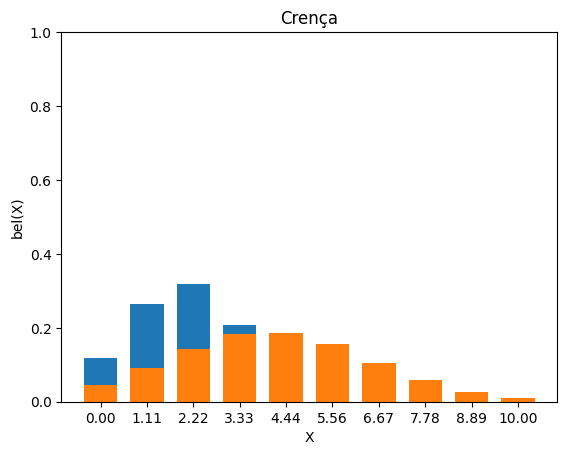

In [14]:
u = 2

bel = norm.pdf(centroides, loc=2, scale=np.sqrt(2))
bel[:] = bel[:]/bel.sum()

show_belief(bel)

predict(bel, u)

show_belief(bel)

In [15]:
# Consistência

bel.min() >= 0, np.allclose(1,bel.sum())

(True, True)

Note que a crença sobre o estado se desloca 2 unidades para a direita e se "dilue", refeltindo o aumento na incerteza (entropia) da estimação de estado. Se dermos um passo menor, o aumento na incerteza é menor, como especificado pelo modelo de transição.

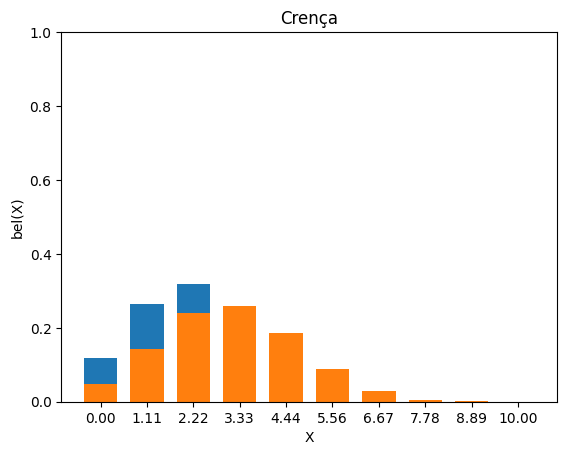

In [16]:
u = 1

bel = norm.pdf(centroides, loc=2, scale=np.sqrt(2))
bel[:] = bel[:]/bel.sum()

show_belief(bel)

predict(bel, u)

show_belief(bel)

In [17]:
# Consistência

bel.min() >= 0, np.allclose(1,bel.sum())

(True, True)

Agora, se observamos $Y=3$, nossa incerteza sobre o estado diminui:

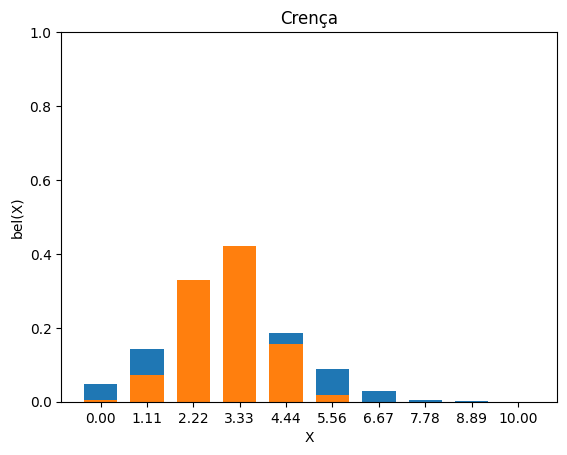

In [18]:
# observa Y=3

show_belief(bel) 

correct(bel, 3.0)

show_belief(bel) 

Para repassarmos a estimação de estado para um controlador, precisamos produzir um valor representativo ou estatística da distribuição. Novamente, vamos ver as duas formas mais comuns: moda e média.

In [19]:
def get_mode(b):
    ''' Extract most probable belief state. '''
    i = np.argmax(b) # distribution mode
    return centroides[i]

def get_mean(b):
    ''' Extract mean belief state value. '''
    return (centroides*b).sum()

In [20]:
x = get_mode(bel)
print('Mode state:', x)
x = get_mean(bel)
print('Mean state:', x)

Mode state: 3.3333333333333335
Mean state: 3.005807584798347


A média é mais adequada quando a distribuição é unimodal (possui apenas um pico) e relativamente simétrica. A moda é mais indicada para distribuições multimodais (vários picos), muito assimétricas ou quando desejamos robustez à anomalias (observações incomuns com baixa probabilidade).

## 💡 Exercício 1

Nossa derivação do filtro de histograma em duas etapas, correção e predição, é desnecessária e ineficiente. Na prática, atualizamos a crença em cada ciclo de atualização do robô, considerando a distância percorrida (velocidade vezes tempo decorrido) e obtendo uma observação.

Escreva a função `update` condensando as duas etapas em uma só. Note que só precisamos normalizar os pesos ao final. Use sua função para simular um robô tomando ações aleatórias $u \in [-1,1]$ e observações uniformes $z \in [x-1, x+1]$.

In [21]:
def update(b, z, u):
    ''' Updates belief weights b with observation z and action u. '''
    # TODO

In [22]:
x = 3 # estado inicial -- atualize estado com valor "verdadeiro" para produzir observação

u = 2*np.random.random()-1 # Para gerar valor aleatório em [-1,1]
z = x + 2*np.random.random()-1

In [23]:
x, u, z

(3, -0.07371805103093454, 3.2774645784579253)

## 💡 Exercício 2

Implemente agora um filtro de histograma 3D para um agente que se move por direção diferencial 2D com imprecisão nos atuadores, guiados por sinais de controle de velocidade angulares das rodas $u = \begin{bmatrix} \dot{\varphi}_l & \dot{\varphi}_r \end{bmatrix}^t$. Vamos assumir que o agente possui um sensor imperfeito que lhe permite medir sua pose ($x,y,\theta$) a qualquer instante. A função de transição do robô é dada por
$$
\begin{bmatrix}
 \dot{x}_A \\ \dot{y}_A \\ \dot{\theta}
\end{bmatrix}= 
\frac{R}{2}
\begin{bmatrix}
\cos \theta & 0 \\ 
\sin \theta & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 1 \\ \frac{1}{L} & -\frac{1}{L}
\end{bmatrix}
\begin{bmatrix}
\dot{\varphi}_l \\ \dot{\varphi}_r
\end{bmatrix}
$$
exceto que $\dot{\varphi}_l$ e $\dot{\varphi}_r$ são medidas com alguma imprecisão.


In [26]:
from DifferentialDrive import DifferentialRobot2

robot = DifferentialRobot2()
print("X[t=0.0] = ", robot.x) # pose inicial [x, y, heading]
# move adiante com velocidade constante por 0,1s [ phi_l = phi_r = 5]
robot.forward(5, 5) 
# mostra pose 
print("X[t=0.1] = ", robot.x)
# medir pose
z = robot.perceive() # recebe medida de sensor 
print("Z[t=0.1] = ", z)
# rodar no eixo com velocidade angular constante por 0,1s [phi_l = -phi_l = -5]
robot.forward(-5, 5) 
# mostra apose
print("X[t=0.2] = ", robot.x)
# medir pose
z = robot.perceive() # recebe medida de sensor 
print("Z[t=0.1] = ", z)

X[t=0.0] =  [0. 0. 0.]
X[t=0.1] =  [ 0.01758221  0.         -0.02543972]
Y[t=0.1] =  [0.04587697 0.02829475 0.00285503]
X[t=0.2] =  [ 1.98941091e-02 -5.88267026e-05  3.29835365e-01]
Y[t=0.1] =  [0.06874004 0.0487871  0.37868129]


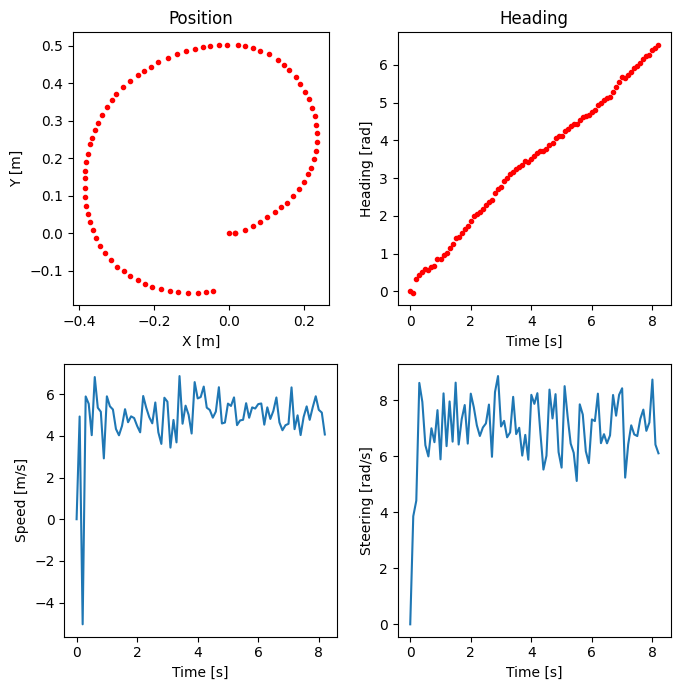

In [25]:
# Exemplo de simulação da trajetória do robô executando um movimento circular
for _ in range(80): 
    robot.forward(5, 7)
# plot trajectory
robot.plot();

Construa um estimador de estado para o robô diferencial, usando um modelo simples de transição com erros gaussianos independentes para cada sinal de controle $\phi_l$ e $\phi_r$ e erro gaussiano para o sensor $z=[x,y,\theta]$. Compare o estado estimado pela média e moda através do erro quadrático médio em relação ao estado real (`robot.x`). Note que você não deve usar o valor real do estado, disponível pela variável `robot.x`, no cálculo de estimação de estado, afinal esse valor indica uma quantidade não observável em um robô real. Note também que sua função de crença agora possui domínio $\mathbb{R}^3$. Você deve estipular a região de suporte da crença de maneira adequada para representar os estados relevantes (se baseie pela figura acima).